# [POC] Foetal Health Classification w Keras

This dataset contains **2126** records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological

The dataset is obtained from [Kaggle.com](https://www.kaggle.com/), an online machine learning community.

Link to the dataset is [Here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

## 1. Importing Packages


In [1]:
# General Python imports
import os
import gc
import time
import tqdm
import random

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
from itertools import cycle

for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        FILE_PATH = os.path.join(dirname, filename)
        print(FILE_PATH)

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

import warnings
warnings.filterwarnings('ignore')     

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

input/fetal_health.csv


## 2. Configs

In [2]:
SEED = 123
random.seed(SEED)

TEST_SIZE = 0.20
VAL_SIZE = 0.15

EPOCHS = 100
BATCH_SIZE = 4

## 3. Dataset

In [3]:
data = pd.read_csv(FILE_PATH)
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


### 3.1 Class Imbalance

In a dataset where the output target values are unbalanced, there exists a class imbalance issue, wherein one class vastly outnumbers the others. This significant disproportion can skew the training of a model towards the larger class, resulting in a biased model that struggles to effectively learn from the minority classes.

Consequently, the model may prioritize predicting the dominant class to achieve high accuracy, without truly capturing the nuances of the data. This imbalance can hinder the model's ability to generalise well to unseen data and may lead to misleading conclusions

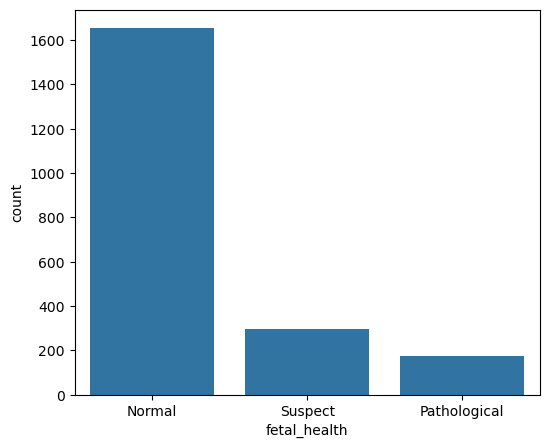

In [6]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(x=data['fetal_health'])

class_labels = ['Normal', 'Suspect', 'Pathological']
ax.set_xticklabels(class_labels)
plt.show()

In [7]:
label = LabelEncoder()
label.fit(data['fetal_health'])
data['fetal_health'] = label.transform(data['fetal_health'])

print("Unique values after transformation:")
print(data['fetal_health'].unique())

Unique values after transformation:
[1 0 2]


### 3.2 Data Split

* Before we can start training our models, we need to **randomly** partition our dataset into training data and testing data.
* Remember that we are trying to make a model that can predict fraudulence of data points that the model has never seen. It would be unwise to measure the accuracy of the model using the same data it trained on.

In [8]:
print(f"Data Split:\nTest size: {TEST_SIZE}\nVali size: {VAL_SIZE}\n")

X = data.drop(columns='fetal_health')
y = data['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=TEST_SIZE,
                                                    random_state=SEED)

print(f"X_train: ({X_train.shape}), y_train: ({y_train.shape})")
print(f"X_test: ({X_test.shape}), y_test: ({y_test.shape})")

val_len = int(X_train.shape[0] * VAL_SIZE)

Data Split:
Test size: 0.2
Vali size: 0.15

X_train: ((1700, 21)), y_train: ((1700,))
X_test: ((426, 21)), y_test: ((426,))


In [9]:
n_features = len(X_train.columns)
n_features

21

### 3.3 Obtain Class Weights

In [10]:
# Calculate class weights from sklearn
class_weight_array = class_weight.compute_class_weight('balanced',
                                                       classes=np.unique(y_train),
                                                       y=y_train)
print(f"Class weights: {class_weight_array}\n")

# Class weights as dictionary for Keras
keys = [0, 1, 2]
class_weight_dict = dict(zip(keys, class_weight_array.T))
print(f"Class weights dict: {class_weight_dict}")

Class weights: [0.42831948 2.40112994 4.01891253]

Class weights dict: {0: 0.42831947593852354, 1: 2.401129943502825, 2: 4.0189125295508275}


### 3.4 Convert to arrays for Keras operation

In [11]:
X_train = X_train.values
X_test = X_test.values

y_train = y_train.values
y_test = y_test.values

## 4. Model

### 4.1 Build the Model

In [12]:
model_0 = Sequential()
model_0.add(Dense(128, activation='relu', input_dim=n_features))
model_0.add(Dense(32, activation='relu'))
model_0.add(Dense(8, activation='relu'))
model_0.add(Dense(3, activation='softmax'))

model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_dim=n_features))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(3, activation='softmax'))

model_2 = Sequential()
model_2.add(Dense(256, activation='relu', input_dim=n_features))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(3, activation='softmax'))

In [13]:
models = [model_0, model_1, model_2]

### 4.2 Train and Evaluate Model

Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.8474 - loss: 0.4290
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


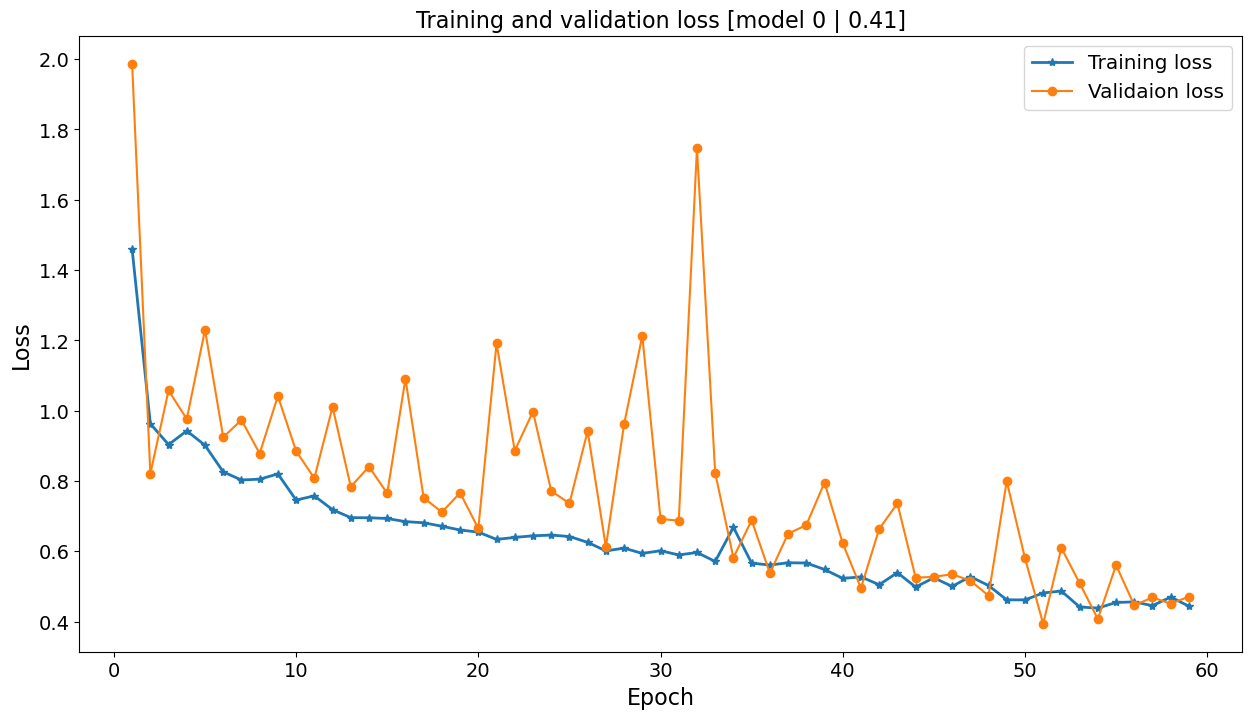

<Figure size 640x480 with 0 Axes>

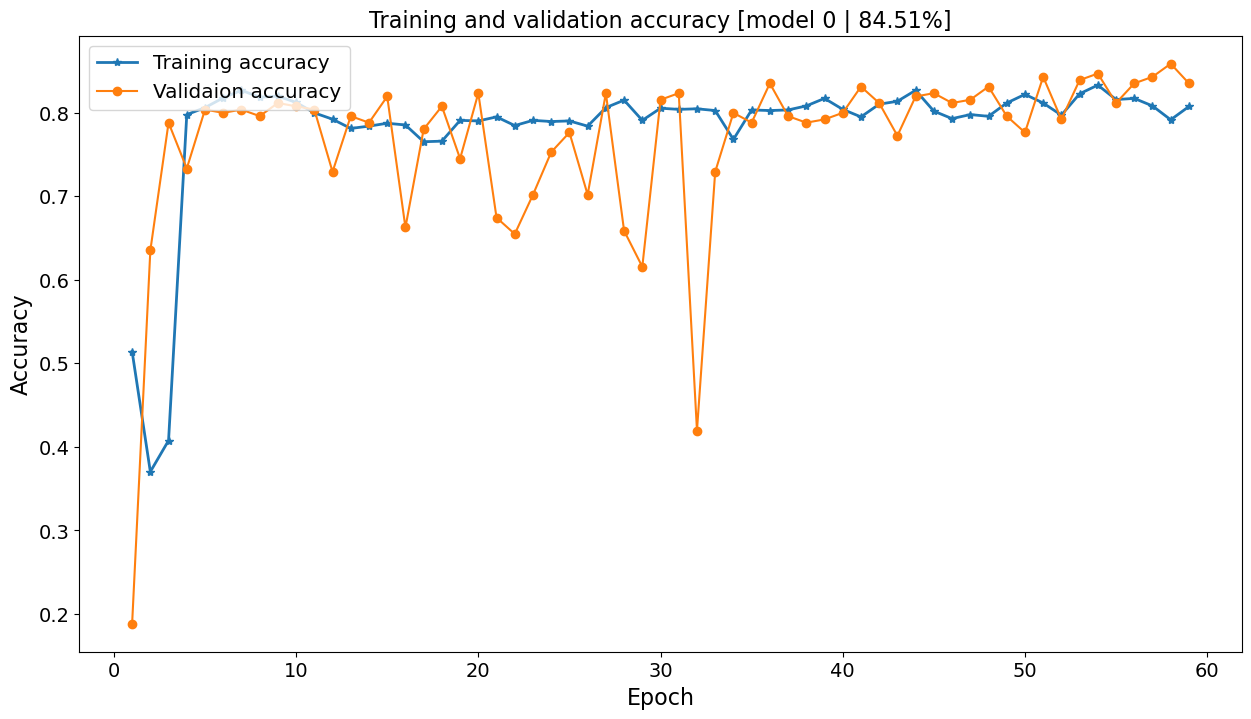

<Figure size 640x480 with 0 Axes>

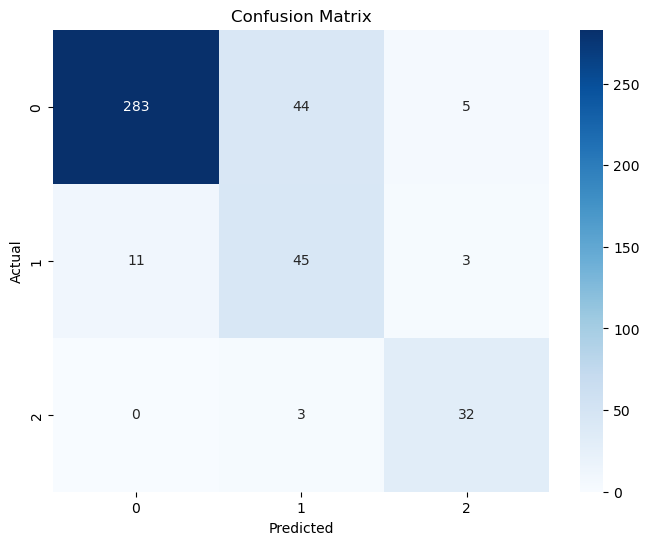

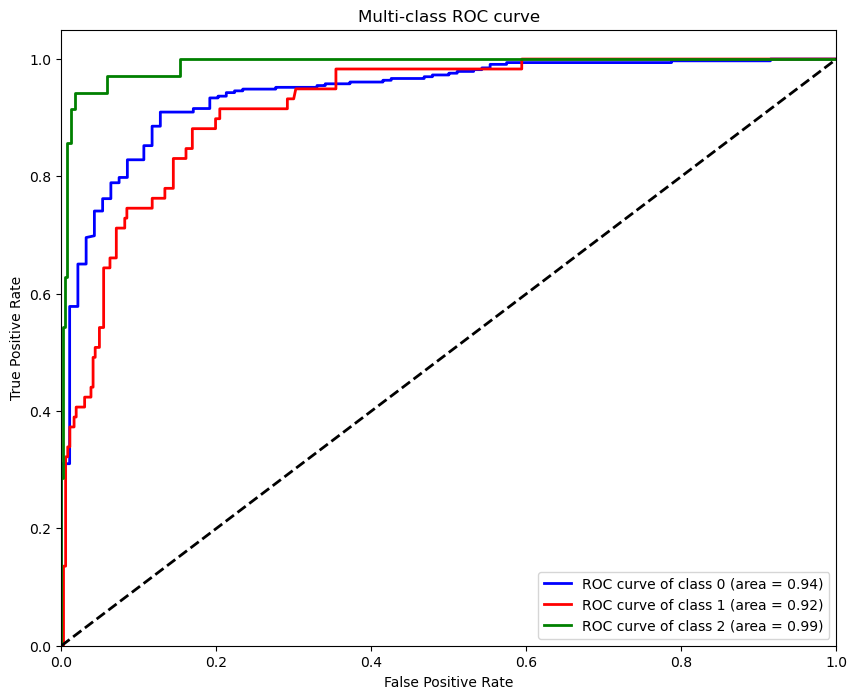

Training Models:  33%|███▎      | 1/3 [00:13<00:26, 13.20s/it]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6037 - loss: 1.0228
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


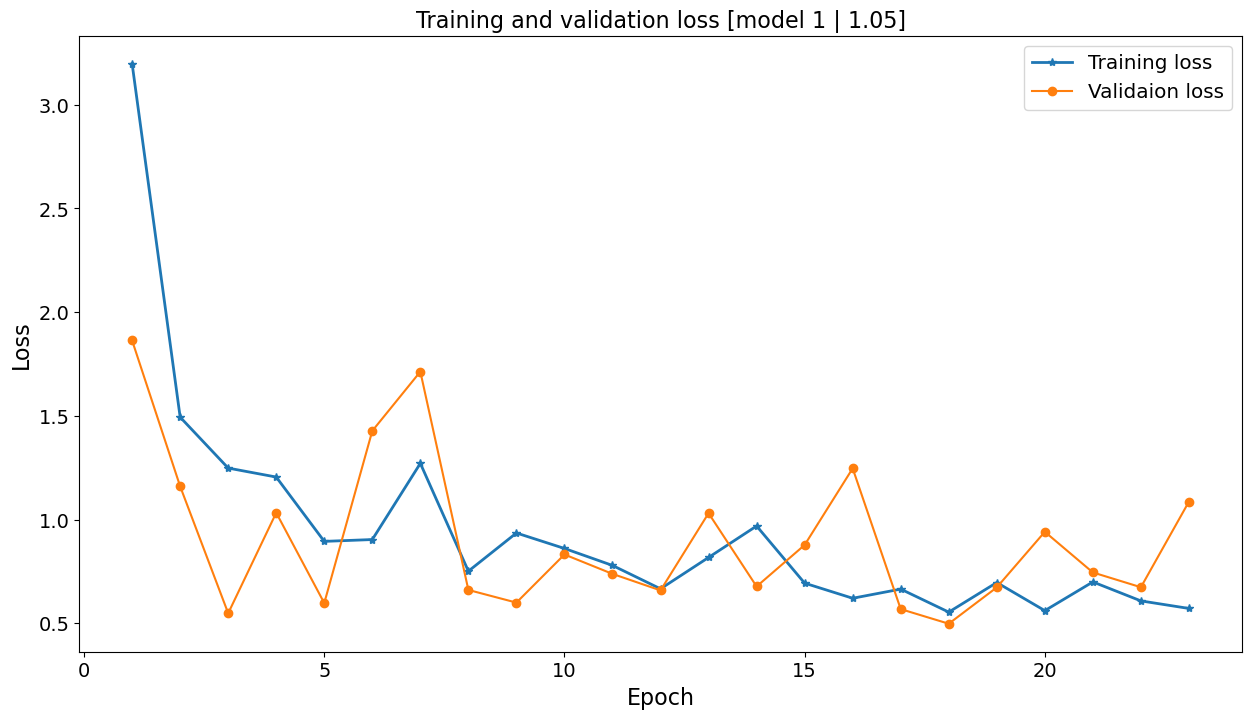

<Figure size 640x480 with 0 Axes>

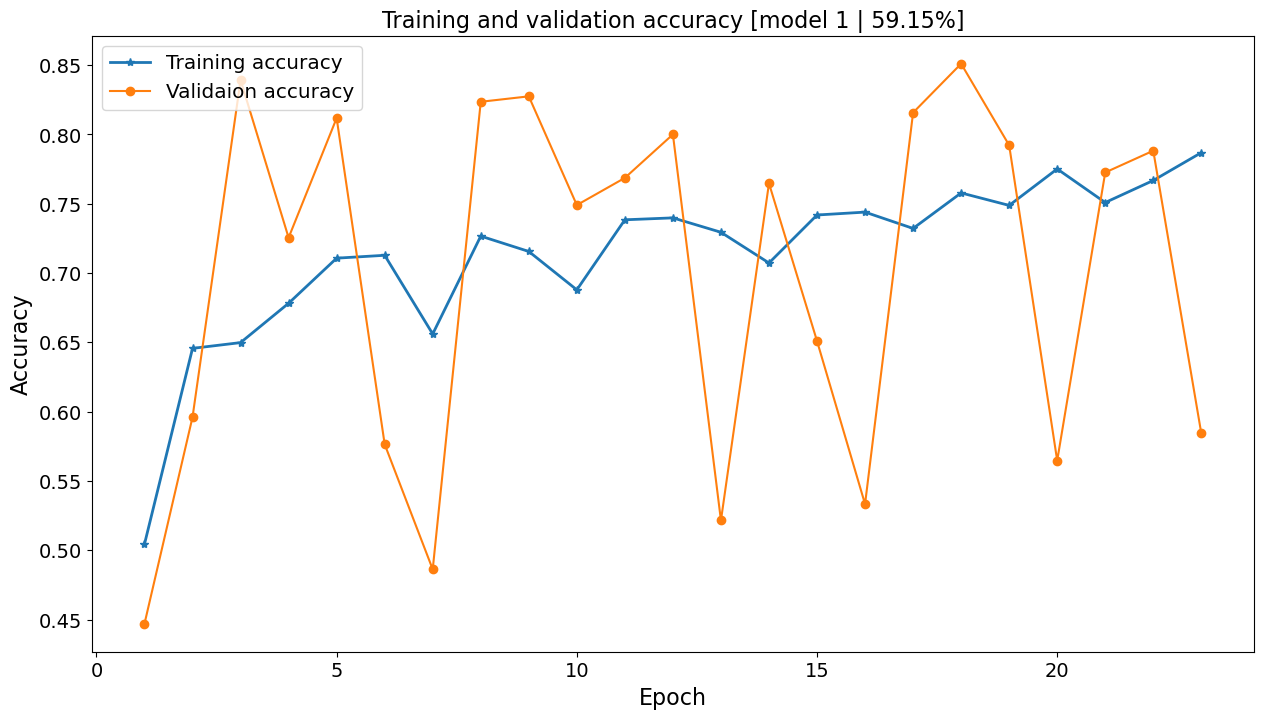

<Figure size 640x480 with 0 Axes>

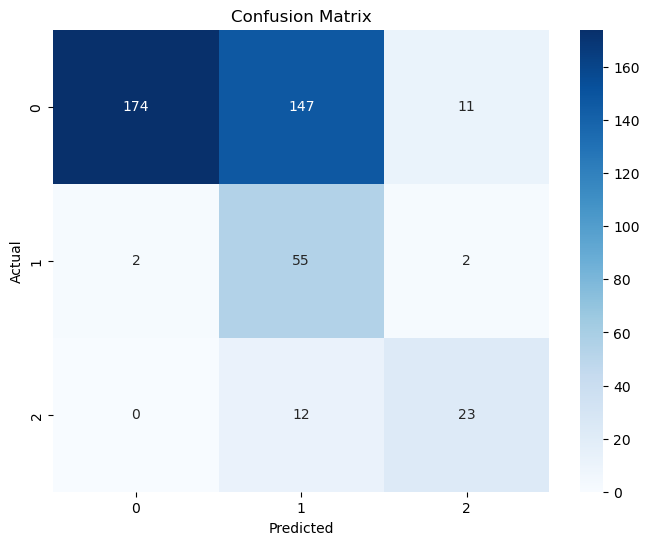

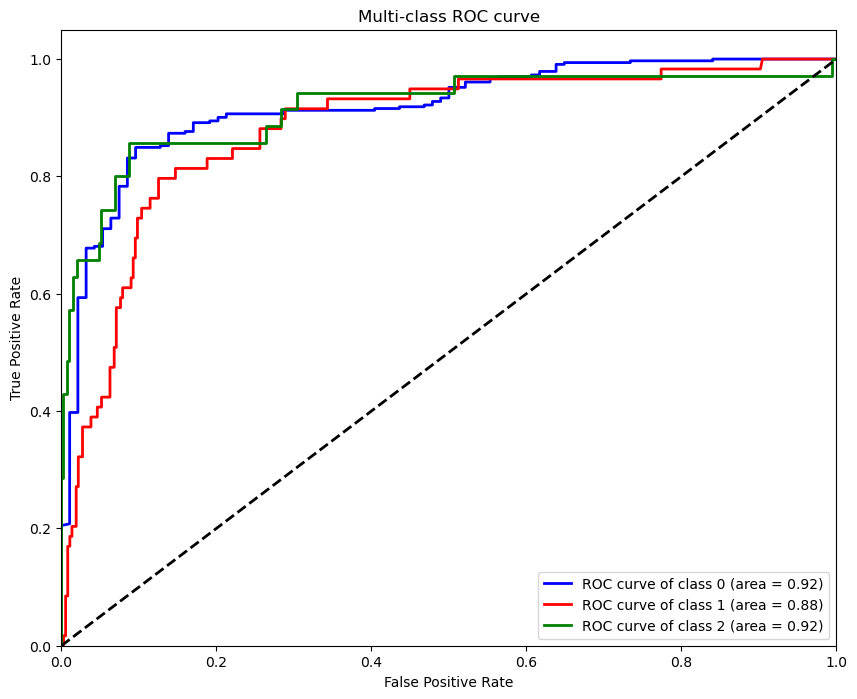

Training Models:  67%|██████▋   | 2/3 [00:18<00:08,  8.50s/it]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.8284 - loss: 0.4194
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


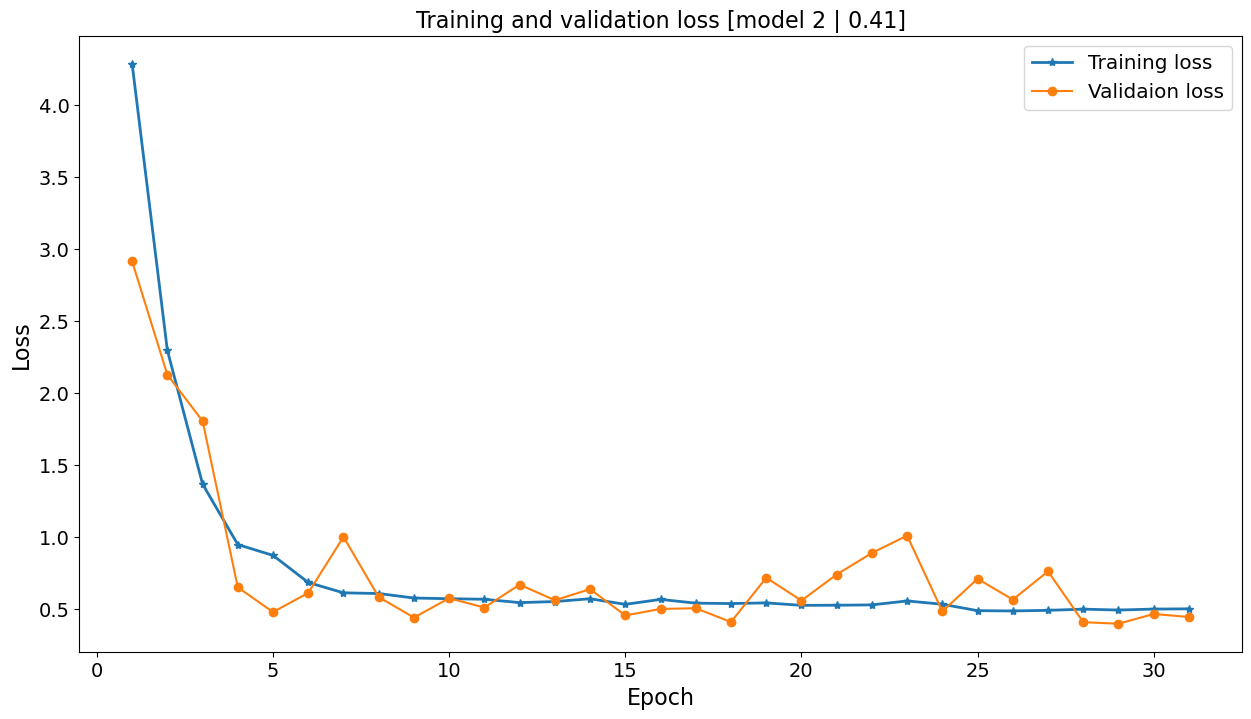

<Figure size 640x480 with 0 Axes>

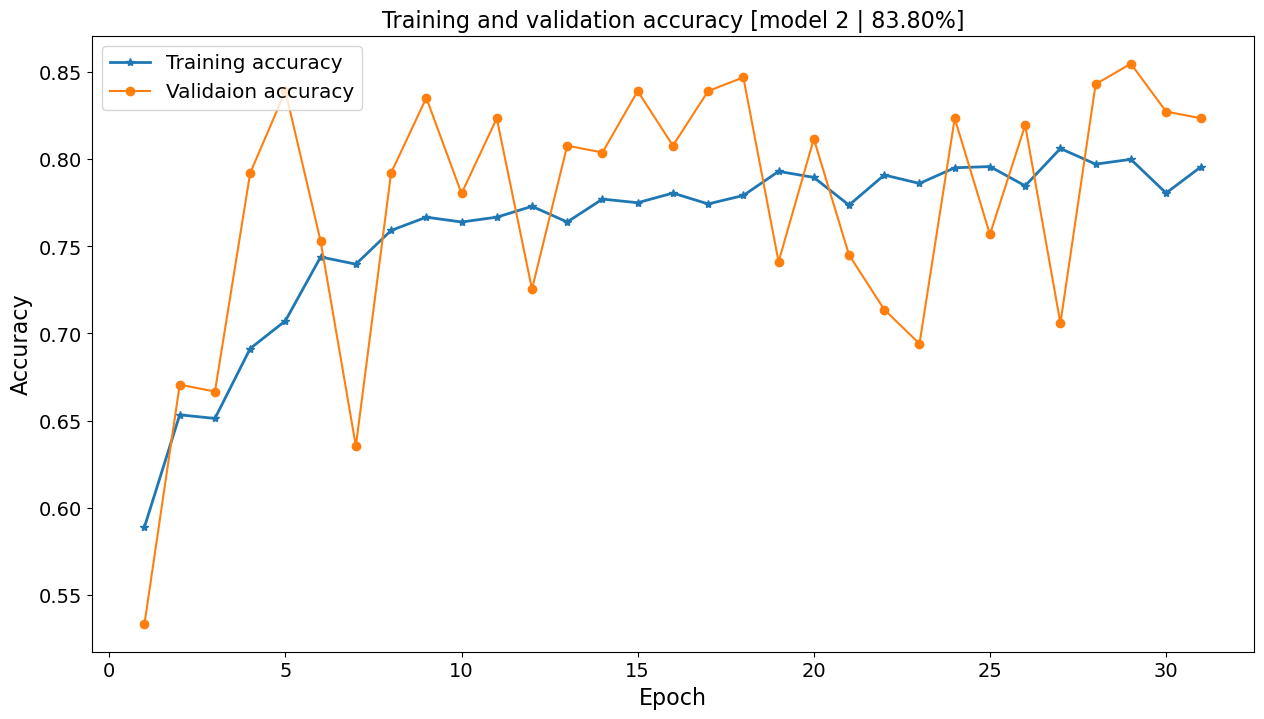

<Figure size 640x480 with 0 Axes>

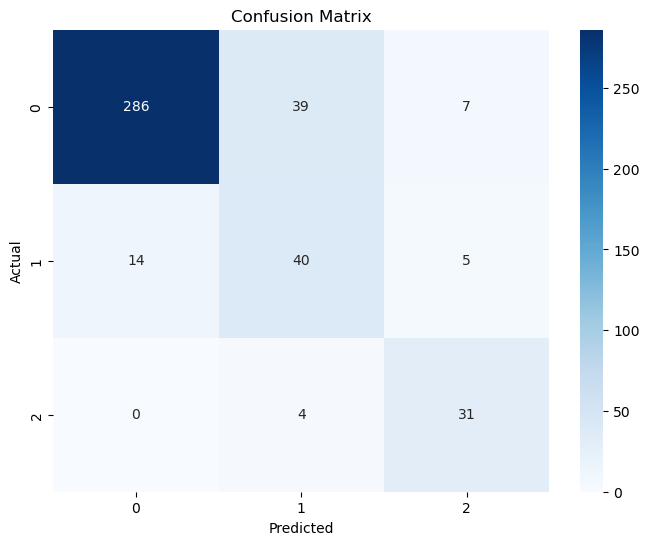

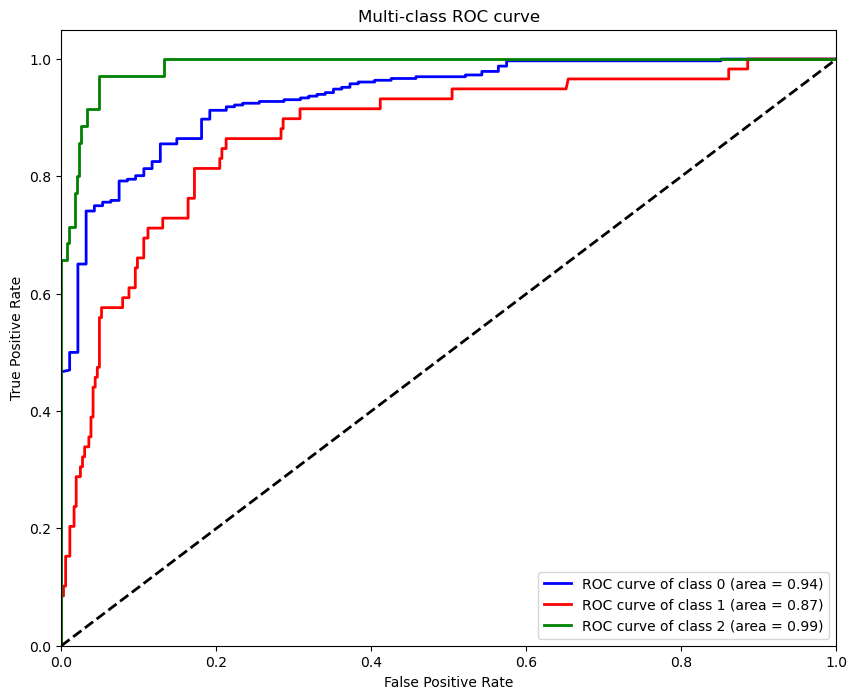

Training Models: 100%|██████████| 3/3 [00:26<00:00,  8.76s/it]


In [14]:
for m, model in enumerate(tqdm.tqdm(models, desc="Training Models")):
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )
    
    X_val = X_train[:val_len]
    y_val = y_train[:val_len]

    X_train_cut = X_train[val_len:]
    y_train_cut = y_train[val_len:]

    # callback to stop the training if no improvement for 5 consecutive epochs
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5.0)

    history = model.fit(X_train_cut, y_train_cut, 
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            class_weight=class_weight_dict,
                            validation_data=(X_val, y_val),
                            callbacks=[callback],
                            verbose=0 # To suppress output log
                        )

    result = model.evaluate(X_test, y_test)
    
    # Predicting the test set results
    y_pred_prob = model.predict(X_test)
    y_pred = y_pred_prob.argmax(axis=1)
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    metrics = history.history['accuracy']
    epochs = range(1, len(metrics) + 1)
    
    # Visualisation of loss and accuracy
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, color='tab:blue', linestyle='-', linewidth=2, marker='*', label='Training loss')
    plt.plot(epochs, val_loss, color='tab:orange', linestyle='-', marker='o', label='Validaion loss')
    plt.title(f'Training and validation loss [model {m} | {result[0]:.2f}]', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='upper right', fontsize='x-large')
    plt.tick_params(labelsize=14)
    plt.show()
    plt.clf()
    
    plt.figure(figsize=(15,8))
    plt.plot(epochs, accuracy, color='tab:blue', linestyle='-', linewidth=2, marker='*', label='Training accuracy')
    plt.plot(epochs, val_accuracy, color='tab:orange', linestyle='-', marker='o', label='Validaion accuracy')
    plt.title(f'Training and validation accuracy [model {m} | {result[1]*100:.2f}%]', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc='upper left', fontsize='x-large')
    plt.tick_params(labelsize=14)
    plt.show()
    plt.clf()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Binarize the output for multiclass
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC curve')
    plt.legend(loc="lower right")
    plt.show()